# Math 170 - Homework 9, Parth Desai

## Setup

In [ ]:
%pip install numpy pandas matplotlib jax jaxlib seaborn scikit-learn tensorflow nbconvert

In [16]:
import numpy as np
import jax
from jax import jit, lax, random, value_and_grad, vmap, grad
import jax.numpy.linalg as jla
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
key = random.PRNGKey(0)
# pyright: ignore[reportGeneralTypeIssues]

## Question 1

In [68]:
def bisect(h, a, b, delta=1e-10):
    p = (a+b)/2
    counter = 0
    while abs(h(p)[0] - h(a)[0]) > delta:
        if h(a)[0]*h(p)[0] > 0:
            a = p
        else:
            b = p
        p = (a+b)/2
        counter += 1
        if counter > 1000:
            break
    return p

import jax
import jax.numpy as jnp

def trust_region_subproblem(b, A, Delta, tol=1e-8, max_iter=100):
    """
    Solve   min  b^T s + 1/2 s^T A s   subject to  ||s|| ≤ Delta
    using standard Moré–Sorensen approach.
    """
    # Unconstrained minimizer
    s_uncon = -jnp.linalg.solve(A, b)
    if jnp.linalg.norm(s_uncon) <= Delta:
        return s_uncon

    # Otherwise we need to solve for lambda >= 0
    # Use Newton iteration on the secular equation:
    # f(lambda) = ||(A + lambda I)^(-1) b|| - Delta = 0

    n = b.size
    lam = 1.0  # initial guess

    for _ in range(max_iter):
        # Solve (A + λI)s = -b
        M = A + lam * jnp.eye(n)
        s = -jnp.linalg.solve(M, b)
        norm_s = jnp.linalg.norm(s)

        # Compute f(λ)
        f = norm_s - Delta
        if jnp.abs(f) < tol:
            break

        # Compute derivative f'(λ) = -s^T (A + λI)^(-1) s / ||s||
        # Solve for w = (A + λI)^(-1) s
        w = jnp.linalg.solve(M, s)
        df = -jnp.dot(s, w) / norm_s

        lam = lam - f / df
        lam = jnp.maximum(lam, 0.0)  # keep λ >= 0

    return s


def tr_newton(fgradf, hessf, x0, delta0, T=1000, eta0=0.1, eta1=0.25, eta2=0.75, gammadown=0.25, gammaup=2.0):
    gradhist = []
    xhist = []
    fhist = []
    x = x0
    delta = delta0
    for _ in tqdm(range(T)):
        fx, gradfx = fgradf(x)
        fhist.append(fx)
        xhist.append(x)
        hessfx = hessf(x)
        s = trust_region_subproblem(gradfx, hessfx, delta)
        rho = (fgradf(x+s)[0] - fx) / (gradfx @ s + 0.5 * s.T @ hessfx @ s)
        if rho > eta0:
            x += s
        if rho < eta1:
            delta *= gammadown
        elif rho > eta2 and jnp.linalg.norm(s) == delta:
            delta = min(gammaup * delta, 100.0)
        # print(gradfx**2)
        gradhist.append(gradfx**2)
    gradhist = jnp.array(gradhist)
    xhist = jnp.array(xhist)
    fhist = jnp.array(fhist)
    return gradhist, xhist, fhist

## Question 2

In [74]:
def weak_wolfe(fgradf, x, p, c1, c2, alpha0):
    a = 0.0
    alpha = alpha0
    while fgradf(x + alpha * p)[0] <= fgradf(x)[0] + c1 * alpha * jnp.dot(fgradf(x)[1], p): # Armijo condition
        if jnp.dot(fgradf(x + alpha * p)[1], -p) <= -c2 * jnp.dot(fgradf(x)[1], p): # Weak Curvature condition
            return alpha
        a = alpha
        alpha *= 2.0
    b = alpha
    while True:
        alpha = (a + b) / 2.0
        if fgradf(x + alpha * p)[0] > fgradf(x)[0] + c1 * alpha * jnp.dot(fgradf(x)[1], p): # If fails Armijo...
            b = alpha
        elif jnp.dot(fgradf(x + alpha * p)[1], -p) > -c2 * jnp.dot(fgradf(x)[1], p): # If fails Weak Curvature...
            a = alpha
        else:
            return alpha
        
def BFGS(fgradf, x0, c1, c2, T=1000):
    M = jnp.eye(len(x0))
    v = fgradf(x0)[1]
    x = x0
    gradhist = []
    xhist = []
    fhist = []
    for _ in tqdm(range(T)):
        p = M@v
        alpha = weak_wolfe(fgradf, x0, p, c1, c2, 1.0)
        s = alpha * p
        x += s
        fx, v_new = fgradf(x)
        y = v_new - v
        delta = jnp.dot(y, s)
        M += (1 + (y.T @ M @ y / delta)) * (jnp.outer(s, s.T) / delta) - ((jnp.outer((M @ y).T, s) + jnp.outer(s.T, y @ M)) / delta)
        v = v_new
        gradhist.append(v**2)
        xhist.append(x)
        fhist.append(fx)
    gradhist = jnp.array(gradhist)
    xhist = jnp.array(xhist)
    fhist = jnp.array(fhist)
    return gradhist, xhist, fhist

## Experiment Block

In [75]:
delta = 1e-10
def f(x: jnp.array) -> float: # type: ignore
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

f_batch = vmap(f)

x_initial = np.array([10.0, 12.5])

fgradf = jit(value_and_grad(f))
hessf = jax.hessian(f)



### Trust Region Newton

100%|██████████| 1000/1000 [00:37<00:00, 26.72it/s]


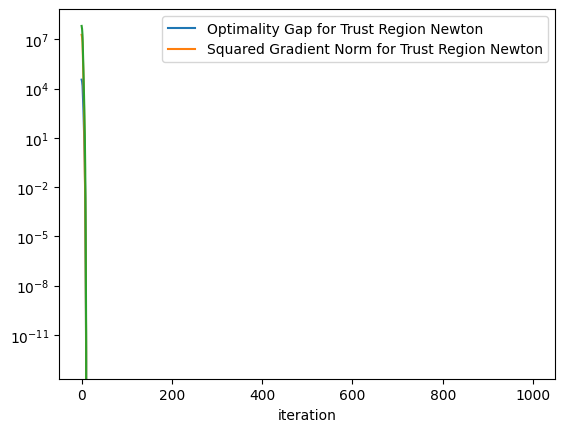

Text(0.5, 1.0, 'Optimizer Trajectory with Objective Contour Plot (Trust Region Newton)')

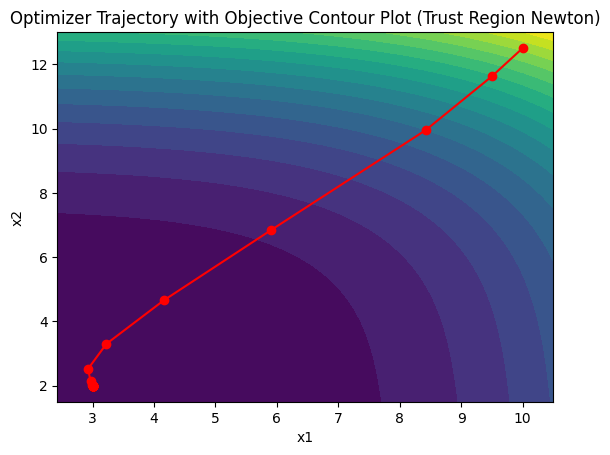

In [78]:
gradhist_trnewton, xhist_trnewton, fhist_trnewton = tr_newton(fgradf, hessf, x_initial, delta0=1.0, T=1000)

plt.semilogy(fhist_trnewton)
plt.semilogy(gradhist_trnewton)
plt.legend(["Optimality Gap for Trust Region Newton", "Squared Gradient Norm for Trust Region Newton"])
plt.xlabel("iteration")
plt.show()
print("")

# create a grid for objective contour plot
x_range = jnp.linspace(jnp.min(xhist_trnewton[:,0]) - .5, jnp.max(xhist_trnewton[:,0]) + .5, 50)
y_range = jnp.linspace(jnp.min(xhist_trnewton[:,1]) - .5, jnp.max(xhist_trnewton[:,1]) + .5, 50)
X, Y = jnp.meshgrid(x_range, y_range)

# batched evaluation
xy = jnp.vstack((jnp.ravel(X), jnp.ravel(Y) )).T
Z = jnp.reshape(f_batch(xy), X.shape)

# plot the contour plot
plt.contourf(X, Y, Z, levels=20)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Objective Function Contour Plot")

# plot the optimizer trajectory on top
plt.plot(xhist_trnewton[:,0], xhist_trnewton[:,1], '-o', color='red')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Optimizer Trajectory with Objective Contour Plot (Trust Region Newton)")

### BFGS

100%|██████████| 1000/1000 [00:00<00:00, 1658.45it/s]


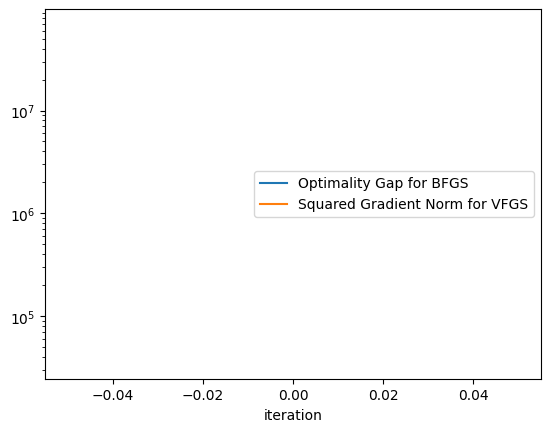

Text(0.5, 1.0, 'Optimizer Trajectory with Objective Contour Plot (BFGS)')

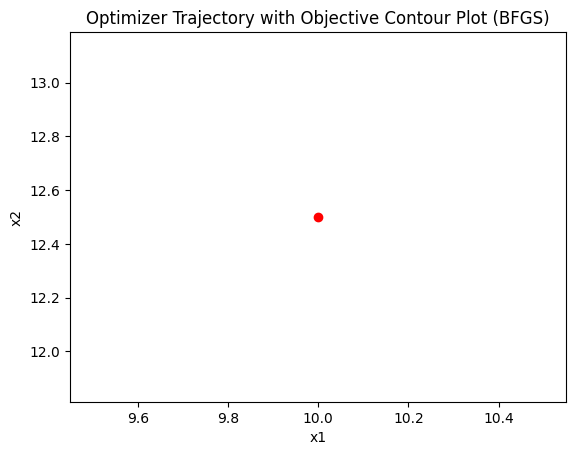

In [81]:
gradhist_bfgs, xhist_bfgs, fhist_bfgs = BFGS(fgradf, x_initial, c1=1e-4, c2=1e-3, T=1000)

plt.semilogy(fhist_bfgs)
plt.semilogy(gradhist_bfgs)
plt.legend(["Optimality Gap for BFGS", "Squared Gradient Norm for VFGS"])
plt.xlabel("iteration")
plt.show()
print("")

# create a grid for objective contour plot
x_range = jnp.linspace(jnp.min(xhist_bfgs[:,0]) - .5, jnp.max(xhist_bfgs[:,0]) + .5, 50)
y_range = jnp.linspace(jnp.min(xhist_bfgs[:,1]) - .5, jnp.max(xhist_bfgs[:,1]) + .5, 50)
X, Y = jnp.meshgrid(x_range, y_range)

# batched evaluation
xy = jnp.vstack((jnp.ravel(X), jnp.ravel(Y) )).T
Z = jnp.reshape(f_batch(xy), X.shape)

# plot the contour plot
plt.contourf(X, Y, Z, levels=20)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Objective Function Contour Plot")

# plot the optimizer trajectory on top
plt.plot(xhist_bfgs[:,0], xhist_bfgs[:,1], '-o', color='red')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Optimizer Trajectory with Objective Contour Plot (BFGS)")